# LIFEsim Project - Brais Gesto Herrera

## Step 1: Spectra simulation from a given catalog

### Importing the catalog

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import random as rd
from astropy import units as u
from scipy.constants import G, Boltzmann, Stefan_Boltzmann

# Load the catalog
catalog = pd.read_csv('2a_example_catalog.txt',sep="\t",low_memory=False)
data = catalog.head(len(catalog))

### Normalizing exoplanet parameters for later use

In [2]:
norm_tp = np.array(data["Tp"][1:]).astype(float)
norm_mp = np.array(data["Mp"][1:]).astype(float)
norm_rp = np.array(data["Rp"][1:]).astype(float)
norm_ts = np.array(data["Ts"][1:]).astype(float)
norm_ms = np.array(data["Ms"][1:]).astype(float)
norm_rs = np.array(data["Rs"][1:]).astype(float)
norm_a = np.array(data["a"][1:]).astype(float)

exo_params = np.column_stack((norm_tp, norm_mp, norm_rp, norm_ts, norm_ms, norm_rs, norm_a))

from sklearn.preprocessing import MinMaxScaler

# Initialize the scaler
scaler = MinMaxScaler(feature_range=(0, 1))  # Default is [0, 1], but you can adjust (e.g., [-1, 1])

# Fit and transform the data
norm_params = scaler.fit_transform(exo_params)

### Classifying the exoplanets according to the literature

In [3]:
def analogous(mp, rp, ts, fp):
    M_earth = 5.972e24  # kg
    R_earth = 6.371e6   # m
    
    if rp > 1.6:
        return ""
        
    Mp = mp * M_earth
    Rp = rp * R_earth
    v_esc = np.sqrt(2*G*Mp/Rp)
    Tp = (fp/(4*Stefan_Boltzmann))**0.25
    S_cosmic = 5e-16*v_esc**4
    
    m_h2o = 18.016*1.660539e-27
    U_h2o = np.sqrt(3*Boltzmann*Tp/m_h2o)
    
    m_co2 = 44.011*1.660539e-27
    U_co2 = np.sqrt(3*Boltzmann*Tp/m_co2)
    
    T_diff = ts - 5780  # Deviation from Sun's T_eff
    S_EM = 0.32 + 5.547e-5*T_diff + 1.526e-9*T_diff**2 - 2.874e-12*T_diff**3 - 5.011e-16*T_diff**4  # Early Mars
    S_RV = 1.776 + 2.136e-4*T_diff + 2.533e-8*T_diff**2 - 1.332e-11*T_diff**3 - 3.097e-15*T_diff**4  # Recent Venus
    
    if fp > S_cosmic:
        # Thin atmosphere
        if 10*U_h2o > v_esc:
            # No water
            if 10*U_co2 > v_esc:
                return "a_Mercury"
            else:
                return "a_Mars"
        else:
            return ""
    else:
        # Some atmosphere
        if S_EM < fp < S_RV:
            return "a_Earth"
        elif S_RV < fp < 25:
            return "a_Venus"
        else:
            return ""

def classify(mp, rp, ts, fp, ec, rs, ds):
    s = analogous(mp, rp, ts, fp)
    
    if s == "":
        # MASS
        if mp < 0.22:
            s += "M"
        elif mp < 2.2:
            s += "E"
        elif mp < 22:
            s += "S"
        elif mp < 127:
            s += "N"
        elif mp < 4450:
            s += "J"
        else:
            s += "D"
            
        # TEMPERATURE
        Rs = rs * 696340000
        Ro = ds * 149597870691
        Td = (ts**4 * (Rs/Ro)**2)**0.25
        
        if Td < 250:
            s += "F"
        elif Td < 450:
            s += "W"
        elif Td < 1000:
            s += "G"
        else:
            s += "R"
            
        # ECCENTRICITY
        s += str(round(ec, 1))[-1]
        
        # DENSITY
        M_earth = 5.972e24
        R_earth = 6.371e6
        Mp = mp * M_earth
        Rp = rp * R_earth
        dens = (3*Mp)/(4*np.pi*Rp**3) / 1000
        
        if dens < 0.25:
            s += "g"
        elif dens < 2:
            s += "w"
        elif dens < 6:
            s += "t"
        elif dens < 13:
            s += "i"
        else:
            s += "s"
            
    return s

### Creating config files, simulating spectra and logging results

In [400]:
# Read the example configuration file with UTF-8 encoding
try:
    with open("C:/Users/gesto/config_ex.txt", "r", encoding="utf-8") as file:
        configex = file.readlines()
except UnicodeDecodeError:
    # Try with latin-1 encoding if UTF-8 fails
    with open("C:/Users/gesto/config_ex.txt", "r", encoding="latin-1") as file:
        configex = file.readlines()

def write_file(i, diameter, grav, a, rv, stype, ts, rs, period, inc, dist, ngas, gases, gtype, abun, gunit, mmw, p_surf, tp, t_surf, abond, mp, rp, density, clase, v_esc, retain_prmtr, rel_vel, fp, ecc, ms, omega, theta, day_length):
    """
    Creates configuration file for a planet and generates its spectrum
    
    Parameters:
    -----------
    i : int
        Planet identifier number
    diameter : float
        Planet diameter in km
    grav : float
        Surface gravity in m/s²
    a : float
        Semi-major axis in AU
    rv : float
        Radial velocity in km/s
    stype : str
        Spectral type of the star
    ts : float
        Star temperature in K
    rs : float
        Star radius in solar radii
    period : float
        Orbital period in days
    inc : float
        Inclination in radians
    dist : float
        Distance from observer in AU
    ngas : str
        Number of gases in the atmosphere
    gases : str
        List of gases in the atmosphere
    gtype : str
        Type codes for gases
    abun : str
        Abundance values for gases
    gunit : str
        Units for gas abundances
    mmw : str
        Mean molecular weight of atmosphere
    p_surf : float
        Surface pressure in bars
    tp : float
        Planetary equilibrium temperature in K
    t_surf : float
        Surface temperature in K
    abond : float
        Bond albedo
    mp : float
        Planet mass in kg
    rp : float
        Planet radius in m
    density : float
        Planet density in g/cm³
    clase : str
        Planet classification
    v_esc : float
        Escape velocity in m/s
    retain_prmtr : float
        Atmospheric retention parameter
    rel_vel : float
        Relative velocity
    fp : float
        Incident flux relative to Earth
    ecc : float
        Eccentricity
    ms : float
        Star mass in kg
    omega : float
        Longitude of periastron in radians
    theta : float
        True anomaly in radians
    day_length : float
        Length of day in Earth days
    """
    config = configex.copy()

    # Update configuration file with planet parameters
    config[1] = "<OBJECT-NAME>Planet " + str(i) + "\n"
    config[3] = "<OBJECT-DIAMETER>%.2f\n" % diameter
    config[4] = "<OBJECT-GRAVITY>%.3f\n" % grav
    config[7] = "<OBJECT-STAR-DISTANCE>%.5f\n" % a
    config[8] = "<OBJECT-STAR-VELOCITY>%.5f\n" % rv
    config[11] = "<OBJECT-STAR-TYPE>" + stype + "\n"
    config[12] = "<OBJECT-STAR-TEMPERATURE>%.1f\n" % ts
    config[13] = "<OBJECT-STAR-RADIUS>%.2f\n" % rs
    config[16] = "<OBJECT-PERIOD>%.8f\n" % period
    config[18] = "<OBJECT-INCLINATION>%.2f\n" % (inc * 180 / np.pi)
    config[23] = "<GEOMETRY-OBS-ALTITUDE>%.4f\n" % dist
    config[39] = "<ATMOSPHERE-NGAS>" + ngas + "\n"
    config[40] = "<ATMOSPHERE-GAS>" + gases + "\n"
    config[41] = "<ATMOSPHERE-TYPE>" + gtype + "\n"
    config[42] = "<ATMOSPHERE-ABUN>" + abun + "\n"
    config[43] = "<ATMOSPHERE-UNIT>" + gunit + "\n"
    config[45] = "<ATMOSPHERE-WEIGHT>" + mmw + "\n"
    config[46] = "<ATMOSPHERE-PRESSURE>%.4f\n" % p_surf
    config[48] = "<ATMOSPHERE-TEMPERATURE>%.2f\n" % t_surf
    config[54] = "<SURFACE-TEMPERATURE>%.2f\n" % t_surf
    config[55] = "<SURFACE-ALBEDO>%.2f\n" % abond
    config[56] = "<SURFACE-EMISSIVITY>%.2f\n" % (1 - abond)

    # Write the configuration file - explicitly use UTF-8 encoding
    with open("democonfig.txt", "w", encoding="utf-8") as fileconfig:
        for z in range(len(config)):
            fileconfig.write(config[z])
    
    # Generate spectrum using PSG API
    os.system('curl --data-urlencode file@democonfig.txt https://psg.gsfc.nasa.gov/api.php > C:/Users/gesto/OneDrive/Desktop/BRAIS/CLASE/MASS/ComputationalAstrobiology/spectra/spectrum_' + str(i) + '.txt')

    # Write detailed catalog entry with all parameters - explicitly use UTF-8 encoding
    with open("C:/Users/gesto/OneDrive/Desktop/BRAIS/CLASE/MASS/ComputationalAstrobiology/spectra/catalog.txt", "a", encoding="utf-8") as cat:
        cat_entry = f"{i}\t{diameter:.4f}\t{grav:.4f}\t{a:.6f}\t{ts:.2f}\t{rs:.4f}\t{mp:.4e}\t{tp:.2f}\t"
        cat_entry += f"{rp:.4e}\t{density:.4f}\t{clase}\t{v_esc:.4f}\t{retain_prmtr:.4f}\t{rel_vel:.4f}\t"
        cat_entry += f"{p_surf:.6f}\t{t_surf:.2f}\t{abond:.4f}\t{fp:.4f}\t{ecc:.4f}\t{ms:.4e}\t"
        cat_entry += f"{period:.4f}\t{inc:.6f}\t{omega:.6f}\t{theta:.6f}\t{day_length:.4f}\t"
        
        # Add atmospheric composition if present
        if ngas != "0":
            cat_entry += f"{gases}\t{abun}\t{gunit}\t{mmw}\n"
        else:
            cat_entry += "None\tNone\tNone\tNone\n"
        
        cat.write(cat_entry)
    
    # Plot the spectrum
    try:
        data = np.genfromtxt('C:/Users/gesto/OneDrive/Desktop/BRAIS/CLASE/MASS/ComputationalAstrobiology/spectra/spectrum_' + str(i) + '.txt')
        plt.figure(figsize=(10, 6))
        plt.plot(data[:, 0], data[:, 1], color='green')
        plt.xlabel('Wavelength (μm)')
        plt.ylabel('Spectrum')
        plt.title(f'Spectrum for Planet {i} - {clase}')
        plt.savefig(f"C:/Users/gesto/OneDrive/Desktop/BRAIS/CLASE/MASS/ComputationalAstrobiology/spectra/spectrum_{i}.png")
        plt.close()
    except:
        print(f"Could not generate plot for planet {i}")

def v_th(gas, t):
    """Calculate thermal velocity for a gas at temperature t"""
    gas_masses = {
        "CO2": 7.34e-26,
        "N2": 4.65e-26,
        "O2": 5.31e-26,
        "H2O": 2.99e-26,
        "CH4": 2.66e-26,
        "H2": 3.32e-27
    }
    
    if gas in gas_masses:
        m = gas_masses[gas]
    else:
        m = 7.34e-26  # Default to CO2 if gas not found
    
    return np.sqrt((2 * 1.38e-23 * t) / m)

def create_config_file(i):
    """
    Create configuration file for planet with index i using data from the catalog
    """
    # Physical constants
    M_earth = 5.972e24  # kg
    R_earth = 6.371e6   # m
    M_sun = 1.988475e30 # kg
    R_sun = 6.957e8     # m
    S_earth = 1361      # W/m²
    G = 6.67e-11        # m³ kg⁻¹ s⁻²
    kb = 1.38e-23       # J/K
    
    # Get planet parameters from catalog
    rp = float(data["Rp"][i]) * R_earth  # Radius in m
    mp = float(data["Mp"][i]) * M_earth  # Mass in kg
    tp = float(data["Tp"][i])            # Equilibrium temperature in K
    a = float(data["a"][i])              # Semi-major axis in AU
    inc = float(data["inc"][i])          # Inclination in radians
    period = float(data["Porb"][i])      # Orbital period in days
    ecc = float(data["ecc"][i])          # Eccentricity
    rs = float(data["Rs"][i]) * R_sun    # Star radius in m
    ms = float(data["Ms"][i]) * M_sun    # Star mass in kg
    stype = data["stype"][i]             # Spectral type
    ts = float(data["Ts"][i])            # Star temperature in K
    dist = float(data["dist"][i])        # Distance in AU
    omega = float(data["omega"][i])      # Longitude of periastron in radians
    theta = float(data["theta"][i])      # True anomaly in radians
    fp = float(data["Finc"][i])          # Incident flux (Earth units)
    abond = float(data["Abond"][i])      # Bond albedo
    
    # Derived parameters
    diameter = 2 * rp / 1000                 # Diameter in km
    density = (3 * mp) / (4 * np.pi * rp**3) / 1000  # Density in g/cm³
    grav = G * mp / rp**2                    # Surface gravity in m/s²
    rv = 0.000636 * (mp / M_earth) * np.sin(inc) * period**(-1/3) * (ms / M_sun)**(-2/3) / (1 - ecc**2)**0.5  # Radial velocity in km/s
    day_length = period if period < 10 and ecc < 0.1 else 1.0  # Day length in Earth days
    rel_vel = rv * (np.cos(omega + theta) + ecc * np.cos(omega))  # Relative velocity
    
    # Atmospheric parameters
    v_esc = np.sqrt((2 * G * mp) / rp)  # Escape velocity in m/s
    retain_prmtr = (G * mp * 7.3e-26) / (kb * rp * tp)  # Atmospheric retention parameter
    
    # Classify the planet
    clase = classify(mp / M_earth, rp / R_earth, ts, fp, ecc, rs / R_sun, a)
    print(f"Planet {i}: {clase}")
    
    # Initialize atmospheric parameters
    p_surf = 0.0
    t_surf = 0.0
    gases = ""
    gtype = ""
    abun = ""
    gunit = ""
    ngas = "0"
    mmw = "0"
    
    # Set parameters based on planet classification
    if clase == "a_Mercury":
        # Negligible atmospheres
        p_surf = 1.05e-13 * (rp / R_earth)**3.168
        t_surf = 45.0 * (fp * S_earth)**0.25 + 0.85
        gases = ""
        gtype = ""
        abun = ""
        gunit = ""
        ngas = "0"
        mmw = "0"
        
    elif clase == "a_Mars":
        p_surf = 0.0467 * (rp / R_earth)**3.168
        t_surf = 42.6 * (fp * S_earth)**0.25 - 0.15
        gases = "CO2,N2,Ar,H2O,CO,CH4"
        gtype = "HIT[2],HIT[22],KZ[18],HIT[1],HIT[5],HIT[6]"
        gunit = "pct,pct,pct,ppm,ppm,ppm"
        co2 = rd.uniform(85, 99)
        n2 = rd.uniform(0.9, 100 - co2)
        ar = rd.uniform(0, 100 - co2 - n2)
        mmw = str(round((co2 * 44 + n2 * 28 + ar * 40) / (co2 + n2 + ar), 2))
        h20 = str(round(rd.uniform(10, 5000), 2)) + ","
        co = str(round(rd.uniform(100, 2000), 2)) + ","
        ch4 = str(round((1 - np.random.power(30)) * 1000 + 1, 2))
        co2 = str(round(co2, 2)) + ","
        n2 = str(round(n2, 2)) + ","
        ar = str(round(ar, 2)) + ","
        abun = co2 + n2 + ar + h20 + co + ch4
        ngas = "6"
        
    elif clase == "a_Venus":
        p_surf = 108.27 * (rp / R_earth)**3.168
        t_surf = 31.7 * (fp * S_earth)**0.25 + 510.85
        gases = "CO2,SO2,H2O,CO,HCl,HF"
        gtype = "HIT[2],HIT[9],HIT[1],HIT[5],HIT[15],HIT[14]"
        gunit = "pct,ppm,ppm,ppm,ppm,ppm"
        co2 = rd.uniform(90, 98)
        so2 = rd.uniform(50, 200)
        h2o = rd.uniform(10, 100)
        co = rd.uniform(10, 100)
        hcl = rd.uniform(0, 10)
        hf = rd.uniform(0, 10)
        mmw = str(round(rd.uniform(43, 45), 2))
        co2 = str(round(co2, 2)) + ","
        so2 = str(round(so2, 2)) + ","
        h2o = str(round(h2o, 2)) + ","
        co = str(round(co, 2)) + ","
        hcl = str(round(hcl, 2)) + ","
        hf = str(round(hf, 2))
        abun = co2 + so2 + h2o + co + hcl + hf
        ngas = "6"
        
    elif clase == "a_Earth":
        p_surf = 1.014 * (rp / R_earth)**3.168
        t_surf = 41.9 * (fp * S_earth)**0.25 + 33.85
        gases = "N2,O2,H2O,CO2,O3,CH4"
        gtype = "HIT[22],HIT[7],HIT[1],HIT[2],HIT[3],HIT[6]"
        gunit = "pct,pct,pct,pct,ppm,ppm"
        n2 = rd.uniform(70, 90)
        o2 = rd.uniform(10, 100 - n2)
        h2o = rd.uniform(0.01, min(100 - n2 - o2, 3))
        co2 = (1 - np.random.power(10)) * (min(100 - n2 - o2 - h2o, 1)) + 0.01
        mmw = str(round((n2 * 28 + o2 * 32 + h2o * 18 + co2 * 44) / (n2 + o2 + h2o + co2), 2))
        o3 = str(round(rd.uniform(0.01, 10), 2)) + ","
        ch4 = str(round(rd.uniform(0.1, 10), 2))
        n2 = str(round(n2, 2)) + ","
        o2 = str(round(o2, 2)) + ","
        h2o = str(round(h2o, 2)) + ","
        co2 = str(round(co2, 2)) + ","
        abun = n2 + o2 + h2o + co2 + o3 + ch4
        ngas = "6"
    
    # Only process Solar System analogues
    if clase in ["a_Venus", "a_Earth", "a_Mars", "a_Mercury"]:
        # Create directory for spectra if it doesn't exist
        if not os.path.exists("C:/Users/gesto/OneDrive/Desktop/BRAIS/CLASE/MASS/ComputationalAstrobiology/spectra"):
            os.makedirs("C:/Users/gesto/OneDrive/Desktop/BRAIS/CLASE/MASS/ComputationalAstrobiology/spectra")
            
        # Create catalog header file if it doesn't exist - explicitly use UTF-8 encoding
        if not os.path.exists("C:/Users/gesto/OneDrive/Desktop/BRAIS/CLASE/MASS/ComputationalAstrobiology/spectra/catalog.txt"):
            with open("C:/Users/gesto/OneDrive/Desktop/BRAIS/CLASE/MASS/ComputationalAstrobiology/spectra/catalog.txt", "w", encoding="utf-8") as cat:
                header = "ID\tDiameter(km)\tGravity(m/s²)\tSMA(AU)\tTstar(K)\tRstar(Rs)\tMplanet(kg)\tTeq(K)\t"
                header += "Rplanet(m)\tDensity(g/cm³)\tClass\tVesc(m/s)\tRetention\tRelVel(km/s)\t"
                header += "Pressure(bar)\tTsurf(K)\tAlbedo\tFinc(Earth)\tEcc\tMstar(kg)\t"
                header += "Period(days)\tInc(rad)\tOmega(rad)\tTheta(rad)\tDayLength(days)\t"
                header += "Gases\tAbundances\tUnits\tMMW\n"
                cat.write(header)
        
        # Generate the spectrum and write to log file
        write_file(i, diameter, grav, a, rv, stype, ts, rs / R_sun, period, inc, dist, ngas, gases, gtype, 
                   abun, gunit, mmw, p_surf, tp, t_surf, abond, mp, rp, density, clase, v_esc, retain_prmtr, 
                   rel_vel, fp, ecc, ms, omega, theta, day_length)

# Main execution loop
def process_planets(start_id, end_id):
    """Process planets from start_id to end_id (inclusive)"""
    for i in range(start_id, end_id + 1):
        try:
            create_config_file(i)
        except Exception as e:
            print(f"Error processing planet {i}: {e}")

# Example usage:
# Ensure the 'classify' function and 'data' DataFrame are loaded before running this
process_planets(3,3)

Planet 3: SG0w


## Step 2: Estimating expected observations for the exoplanets in the catalog

### Setting up simulation variables

In [4]:
scenario = 'baseline' # Options: 'basline', 'pessimistic', 'optimistic'
spectral_resolution = 50  # Resolving power
minimum_wavelength = 4 # Minimum wavelength of the spectrometer in micron
maximum_wavelength = 18 # Maximum wavelength of the spectrometer in micron
integration_time = 55*60*60  # Overall integration time in s
exozodi_level = 3  # Exozodi level in zodis

def set_variables(i):
    planet_radius = float(data["Rp"][i])  # Planet effective radius in Earth radii
    planet_angular_separation = float(data["a"][i])/float(data["dist"][i])  # Planet angular separation from host star in arcsec
    star_distance = float(data["dist"][i])  # Distance to the target system in pc
    star_temperature = float(data["Ts"][i]) # Star effective temperature in K
    star_radius = float(data["Rs"][i])  # Star effective radius in Solar radii
    return planet_radius, planet_angular_separation, star_distance, star_temperature, star_radius

### Setting up LIFEsim Pipeline

In [5]:
import lifesim

# Create bus
bus = lifesim.Bus()

# Set the baseline scenario
bus.data.options.set_scenario(scenario)

# Set some options manually
bus.data.options.set_manual(spec_res=spectral_resolution)
bus.data.options.set_manual(wl_min=minimum_wavelength)
bus.data.options.set_manual(wl_max=maximum_wavelength)

# Create the instrument and add it to the bus
instrument = lifesim.Instrument(name='inst')
bus.add_module(instrument)

# Create the transmission map and add it to the bus
transm = lifesim.TransmissionMap(name='transm')
bus.add_module(transm)

# Create the noise sources and add them to the bus
exo = lifesim.PhotonNoiseExozodi(name='exo')
bus.add_module(exo)

local = lifesim.PhotonNoiseLocalzodi(name='local')
bus.add_module(local)

star = lifesim.PhotonNoiseStar(name='star')
bus.add_module(star)

# Connect all modules
bus.connect(('inst', 'transm'))
bus.connect(('inst', 'exo'))
bus.connect(('inst', 'local'))
bus.connect(('inst', 'star'))
bus.connect(('star', 'transm'))

### Obtaining estimated observation of spectra

In [251]:
import lifesim
from lifesim.util.importer import SpectrumImporter
from spectres import spectres
from sklearn.preprocessing import MinMaxScaler

with open("C:/Users/gesto/OneDrive/Desktop/BRAIS/CLASE/MASS/ComputationalAstrobiology/spectra/catalog.txt") as cat:
    cat.readline()
    file = cat.readlines()
    all_spectra = []
    all_params = []

    for i in range(len(file)):
        id_p = int(file[i].split("\t")[0])

        if id_p < 0:

            print(id_p)
            planet_radius, planet_angular_separation, star_distance, star_temperature, star_radius = set_variables(id_p)
        
            # Create bus
            bus = lifesim.Bus()
            
            # Set the baseline scenario
            bus.data.options.set_scenario(scenario)
            
            # Set some options manually
            bus.data.options.set_manual(spec_res=spectral_resolution)
            bus.data.options.set_manual(wl_min=minimum_wavelength)
            bus.data.options.set_manual(wl_max=maximum_wavelength)
        
            # Create the instrument and add it to the bus
            instrument = lifesim.Instrument(name='inst')
            bus.add_module(instrument)
            
            # Create the transmission map and add it to the bus
            transm = lifesim.TransmissionMap(name='transm')
            bus.add_module(transm)
        
            # Create the noise sources and add them to the bus
            exo = lifesim.PhotonNoiseExozodi(name='exo')
            bus.add_module(exo)
            
            local = lifesim.PhotonNoiseLocalzodi(name='local')
            bus.add_module(local)
            
            star = lifesim.PhotonNoiseStar(name='star')
            bus.add_module(star)
            
            # Connect all modules
            bus.connect(('inst', 'transm'))
            bus.connect(('inst', 'exo'))
            bus.connect(('inst', 'local'))
            bus.connect(('inst', 'star'))
            bus.connect(('star', 'transm'))
            
            importer = SpectrumImporter()
            importer.do_import(pathtotext="C:/Users/gesto/OneDrive/Desktop/BRAIS/CLASE/MASS/ComputationalAstrobiology/spectra/spectrum_"+str(id_p)+".txt",
                               x_string='micron',
                               y_string='ph m-2 s-1 micron-1',
                               radius_p_spectrum=None,
                               radius_p_target=planet_radius,
                               distance_s_spectrum=10.,
                               distance_s_target=star_distance,
                               integration_time=0)
            
            flux_planet_spectrum = [importer.x_data, importer.y_data]
        
            snr, flux, noise = instrument.get_spectrum(temp_s=star_temperature,
                                                   radius_s=star_radius,
                                                   distance_s=star_distance,
                                                   lat_s=0.78, # In radians
                                                   z=exozodi_level,
                                                   angsep=planet_angular_separation,
                                                   flux_planet_spectrum=flux_planet_spectrum, # In ph m-3 s-1 over m
                                                   integration_time=integration_time,
                                                   safe_mode=False)
        
            # Rescale original spectrum to match amount of bins for plotting
            flux_planet_spectrum_rescaled = spectres(new_wavs=instrument.data.inst['wl_bin_edges'],
                                            spec_wavs=flux_planet_spectrum[0].value,
                                            spec_fluxes=flux_planet_spectrum[1].value,
                                            edge_mode=True)
            
            # Compute one draw from noise distribution
            random_noise = np.random.normal(0,abs(flux_planet_spectrum_rescaled/snr[1]),
                                            size = flux_planet_spectrum_rescaled.shape)
        
            obs_spec = flux_planet_spectrum_rescaled+random_noise
            sdata = []
            
            for i in range(len(obs_spec)):
                sdata.append([obs_spec[i],np.arange(len(flux))[i]])
            
            scaler = MinMaxScaler()
            norm_spec = scaler.fit_transform(sdata)[:,0]
        
            # Mask fluxes where SNR < 5
            
            for z in range(len(norm_spec)):
                if snr[1][z] < 5:
                    norm_spec[z] = np.nan

            #We discard spectra where more than 40 points are nan
            if np.isnan(norm_spec).sum() < 40:
                np.save("C:/Users/gesto/OneDrive/Desktop/BRAIS/CLASE/MASS/ComputationalAstrobiology/spectra/norm_spectrum_"+str(id_p)+".npy",norm_spec)
                np.save("C:/Users/gesto/OneDrive/Desktop/BRAIS/CLASE/MASS/ComputationalAstrobiology/spectra/snr_"+str(id_p)+".npy",snr[1])
                all_spectra.append(norm_spec)
                all_params.append(norm_params[id_p])
            
    all_spectra = np.array(all_spectra)
    all_params = np.array(all_params)
    """
    plt.title("Normalized and weighted spectrum")
    plt.xlabel('Wavelength ($\mu$m)')
    plt.xticks(ticks=np.arange(len(flux))[::6], labels=np.round(snr[0][::6]*1e6, 1))
    plt.plot(np.arange(len(flux)),norm_spec,"k*")
    plt.show()
    """

### Example: visualizing one expected observation

C:\Users\gesto\anaconda3\envs\envLIFE\lib\site-packages\lifesim\instrument\instrument.py:420: UserWarning: The get_spectrum function was implemented with a major bug between versions 0.2.16 and 0.2.24 in which the noise level was twice as large as the correct value. If you created results with the versions in question, please validate them with the latest version of LIFEsim.
  warn('The get_spectrum function was implemented with a major bug between versions 0.2.16 '


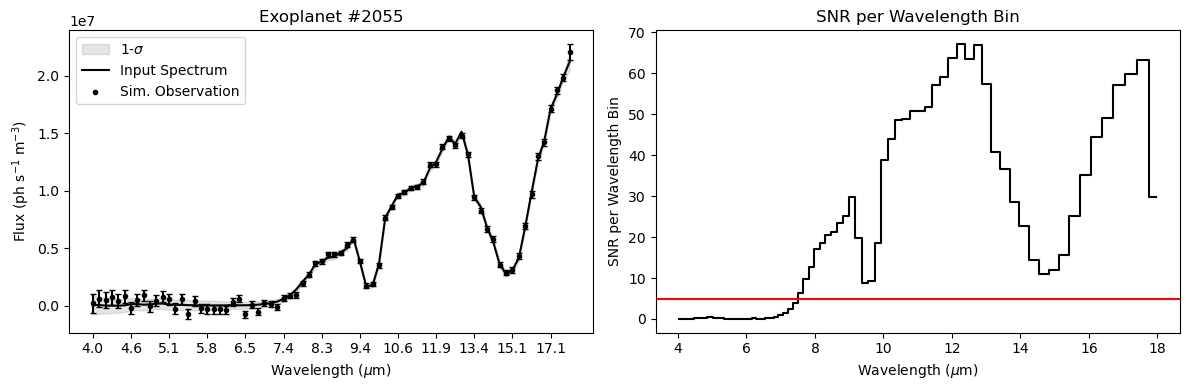

In [6]:
id_p = 2055

from lifesim.util.importer import SpectrumImporter

planet_radius, planet_angular_separation, star_distance, star_temperature, star_radius = set_variables(id_p)

# Import the spectrum, setting the planet properties
importer = SpectrumImporter()
importer.do_import(pathtotext='C:/Users/gesto/OneDrive/Desktop/BRAIS/CLASE/MASS/ComputationalAstrobiology/spectra/spectrum_'+ str(id_p) +'.txt',
                   x_string='micron',
                   y_string='ph m-2 s-1 micron-1',
                   radius_p_spectrum=None,
                   radius_p_target=planet_radius,
                   distance_s_spectrum=10.,
                   distance_s_target=star_distance,
                   integration_time=0)

flux_planet_spectrum = [importer.x_data, importer.y_data]

"""
# Plot input spectrum
plt.plot(importer.x_data, importer.y_data, color='black')
plt.title('Input Spectrum')
plt.xlabel(f'Wavelength ({str(importer.x_data.unit)})')
plt.ylabel(f'Planet Flux ({str(importer.y_data.unit)})')
plt.show()
"""

from spectres import spectres


snr, flux, noise = instrument.get_spectrum(temp_s=star_temperature,
                                           radius_s=star_radius,
                                           distance_s=star_distance,
                                           lat_s=0.78, # In radians
                                           z=exozodi_level,
                                           angsep=planet_angular_separation,
                                           flux_planet_spectrum=flux_planet_spectrum, # In ph m-3 s-1 over m
                                           integration_time=integration_time,
                                           safe_mode=False)

#@title 1.A.6) Plot the Simulated Observation Results

# Rescale original spectrum to match amount of bins for plotting
flux_planet_spectrum_rescaled = spectres(new_wavs=instrument.data.inst['wl_bin_edges'],
                                spec_wavs=flux_planet_spectrum[0].value,
                                spec_fluxes=flux_planet_spectrum[1].value,
                                edge_mode=True)

# Compute one draw from noise distribution
random_noise = np.random.normal(0,abs(flux_planet_spectrum_rescaled/snr[1]),
                                size = flux_planet_spectrum_rescaled.shape)

# Plot the input spectrum and measured spectrum
import matplotlib.pyplot as plt
import numpy as np

# Create the figure and subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# --- First subplot: Input Spectrum and Simulated Observation ---
axes[0].fill_between(np.arange(len(flux)),
                     flux_planet_spectrum_rescaled - flux_planet_spectrum_rescaled / snr[1],
                     flux_planet_spectrum_rescaled + flux_planet_spectrum_rescaled / snr[1],
                     color='black', alpha=0.1, label='1-$\sigma$')

axes[0].plot(flux_planet_spectrum_rescaled, color='black', label='Input Spectrum')

axes[0].scatter(np.arange(len(flux)), flux_planet_spectrum_rescaled + random_noise,
                color='black', marker='.', label='Sim. Observation')

axes[0].errorbar(np.arange(len(flux)), flux_planet_spectrum_rescaled + random_noise,
                 yerr=abs(flux_planet_spectrum_rescaled / snr[1]), color='black', capsize=2, ls='none')

# axes[0].set_title(f'Input Spectrum and Simulated Observation ({scenario})')
axes[0].set_title("Exoplanet #2055")
axes[0].set_xlabel('Wavelength ($\mu$m)')
axes[0].set_xticks(np.arange(len(flux))[::6])
axes[0].set_xticklabels(np.round(snr[0][::6] * 1e6, 1))
axes[0].set_ylabel('Flux (ph s$^{-1}$ m$^{-3}$)')
axes[0].legend()

# --- Second subplot: SNR per Wavelength Bin ---
axes[1].step(snr[0] * 1e6, snr[1], c='black')
axes[1].axhline(5, c="r")
axes[1].set_title('SNR per Wavelength Bin')
axes[1].set_xlabel('Wavelength ($\mu$m)')
axes[1].set_ylabel('SNR per Wavelength Bin')

plt.tight_layout()
plt.show()

## Step 3: Pre-clustering spectra into spectral types using a SOM

### Get normalized abundances of gases

In [7]:
n2, o2, h2o, co2, o3, ch4, so2, co, hcl, hf, ar = [],[],[],[],[],[],[],[],[],[],[]
all_abund = []

with open("C:/Users/gesto/OneDrive/Desktop/BRAIS/CLASE/MASS/ComputationalAstrobiology/spectra/catalog.txt") as cat:
    cat.readline()
    file = cat.readlines()

for i in range(len(file)):
    gases = file[i].split("\t")[-4].split(",")
    abundances = file[i].split("\t")[-3].split(",")
    id_p = int(file[i].split("\t")[0])

    if os.path.isfile("C:/Users/gesto/OneDrive/Desktop/BRAIS/CLASE/MASS/ComputationalAstrobiology/spectra/norm_spectrum_"+str(id_p)+".npy"):

        if "N2" in gases:
            an2 = float(abundances[gases.index("N2")])
        else:
            an2 = 0
    
        if "O2" in gases:
            ao2 = float(abundances[gases.index("O2")])
        else:
            ao2 = 0

        if "H2O" in gases:
            if "HF" in gases:
                ah2o = float(abundances[gases.index("H2O")])/10000
            else:
                ah2o = float(abundances[gases.index("H2O")])
        else:
            ah2o = 0
    
        if "CO2" in gases:
            aco2 = float(abundances[gases.index("CO2")])
        else:
            aco2 = 0
    
        if "O3" in gases:
            ao3 = float(abundances[gases.index("O3")])
        else:
            ao3 = 0

        if "CH4" in gases:
            ach4 = float(abundances[gases.index("CH4")])
        else:
            ach4 = 0
    
        if "SO2" in gases:
            aso2 = float(abundances[gases.index("SO2")])
        else:
            aso2 = 0
    
        if "CO" in gases:
            aco = float(abundances[gases.index("CO")])
        else:
            aco = 0

        if "HCl" in gases:
            ahcl = float(abundances[gases.index("HCl")])
        else:
            ahcl = 0
    
        if "HF" in gases:
            ahf = float(abundances[gases.index("HF")])
        else:
            ahf = 0
    
        if "Ar" in gases:
            aar = float(abundances[gases.index("Ar")])
        else:
            aar = 0
        n2.append(an2)
        o2.append(ao2)
        h2o.append(ah2o)
        co2.append(aco2)
        o3.append(ao3)
        ch4.append(ach4)
        all_abund.append([an2,ao2,ah2o,aco2,ao3,ach4])

all_abund = np.array(all_abund)

from sklearn.preprocessing import MinMaxScaler

# Initialize the scaler
scaler = MinMaxScaler(feature_range=(0, 1))  # Default is [0, 1], but you can adjust (e.g., [-1, 1])

# Fit and transform the data
norm_abund = scaler.fit_transform(all_abund)

### Import normalized spectra and exoplanet parameters

In [8]:
import os.path

habitability_array = 1*np.load("C:/Users/gesto/anaconda3/envs/envLIFE/Lib/site-packages/lifesim/gui/habitablearray.npy")

with open("C:/Users/gesto/OneDrive/Desktop/BRAIS/CLASE/MASS/ComputationalAstrobiology/spectra/catalog.txt") as cat:
    cat.readline()
    file = cat.readlines()
    all_spectra = []
    all_params = []
    og_params = []
    all_hab = []

    for i in range(len(file)):
        id_p = int(file[i].split("\t")[0])

        if os.path.isfile("C:/Users/gesto/OneDrive/Desktop/BRAIS/CLASE/MASS/ComputationalAstrobiology/spectra/norm_spectrum_"+str(id_p)+".npy"):
            all_spectra.append(np.load("C:/Users/gesto/OneDrive/Desktop/BRAIS/CLASE/MASS/ComputationalAstrobiology/spectra/norm_spectrum_"+str(id_p)+".npy"))
            all_params.append(norm_params[id_p])
            og_params.append(exo_params[id_p])
            all_hab.append(habitability_array[id_p])
            
    all_spectra = np.array(all_spectra)
    all_params = np.array(all_params)
    og_params = np.array(og_params)

### Initialization of SOM

In [9]:
import numpy as np
import matplotlib.pyplot as plt

class NaNAwareSOM:
    def __init__(self, x, y, input_len, sigma=1.0, learning_rate=0.5):
        self.x = x
        self.y = y
        self.input_len = input_len
        self.sigma = sigma
        self.learning_rate = learning_rate
        self.weights = np.random.rand(x, y, input_len)
        self.activation_map = np.zeros((x, y))

    def _nan_euclidean_distance(self, x, w):
        mask = ~np.isnan(x)
        if not np.any(mask):
            return np.inf
        diff = x[mask] - w[mask]
        return np.linalg.norm(diff)

    def winner(self, x):
        min_dist = np.inf
        winner_coords = (0, 0)
        for i in range(self.x):
            for j in range(self.y):
                dist = self._nan_euclidean_distance(x, self.weights[i, j])
                if dist < min_dist:
                    min_dist = dist
                    winner_coords = (i, j)
        return winner_coords

    def _update_weights(self, x, winner, iteration, max_iter):
        learning_rate = self.learning_rate * np.exp(-iteration / max_iter)
        sigma = self.sigma * np.exp(-iteration / max_iter)

        for i in range(self.x):
            for j in range(self.y):
                d = np.linalg.norm(np.array([i, j]) - np.array(winner))
                influence = np.exp(-d**2 / (2 * sigma**2))
                mask = ~np.isnan(x)
                self.weights[i, j, mask] += influence * learning_rate * (x[mask] - self.weights[i, j, mask])

    def train(self, data, num_iteration):
        for it in range(num_iteration):
            idx = np.random.randint(len(data))
            x = data[idx]
            winner = self.winner(x)
            self._update_weights(x, winner, it, num_iteration)

    def distance_map(self):
        umatrix = np.zeros((self.x, self.y))
        for i in range(self.x):
            for j in range(self.y):
                neighbors = []
                if i > 0: neighbors.append(self.weights[i - 1, j])
                if i < self.x - 1: neighbors.append(self.weights[i + 1, j])
                if j > 0: neighbors.append(self.weights[i, j - 1])
                if j < self.y - 1: neighbors.append(self.weights[i, j + 1])
                dists = [np.linalg.norm(self.weights[i, j] - n) for n in neighbors]
                umatrix[i, j] = np.mean(dists)
        return umatrix

### Running the SOM

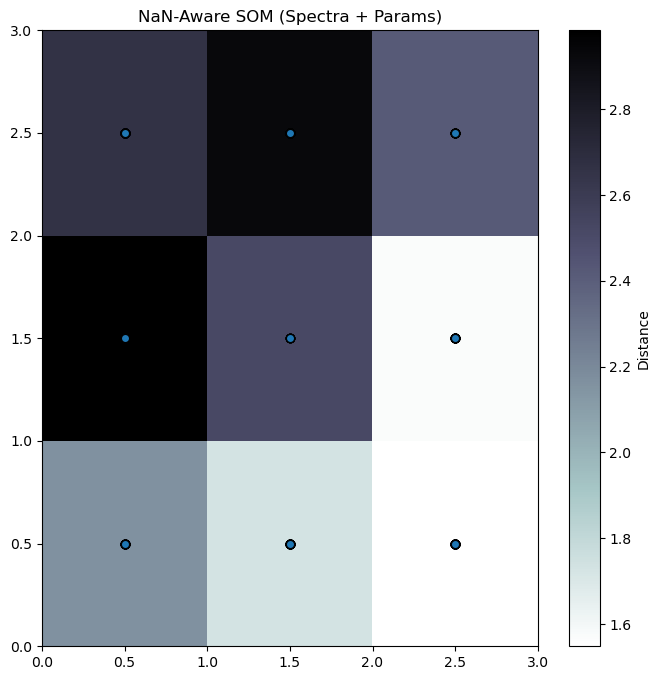

In [10]:
# Combine spectra and params
combined_input = np.hstack((all_spectra, np.column_stack((all_params,norm_abund))))  # NaNs allowed in spectra

# Initialize and train the SOM
som = NaNAwareSOM(x=3, y=3, input_len=combined_input.shape[1], sigma=1.0, learning_rate=0.05)
som.train(combined_input, num_iteration=100000)

# Plot the distance map
plt.figure(figsize=(8, 8))
plt.pcolor(som.distance_map().T, cmap='bone_r')
plt.colorbar(label='Distance')

# Plot input samples
for i, x in enumerate(combined_input):
    win = som.winner(x)
    plt.plot(win[0] + 0.5, win[1] + 0.5, 'o', markerfacecolor='C0', markeredgecolor='k', markersize=6)

plt.title("NaN-Aware SOM (Spectra + Params)")
plt.show()


### Visualizing average spectra per SOM square

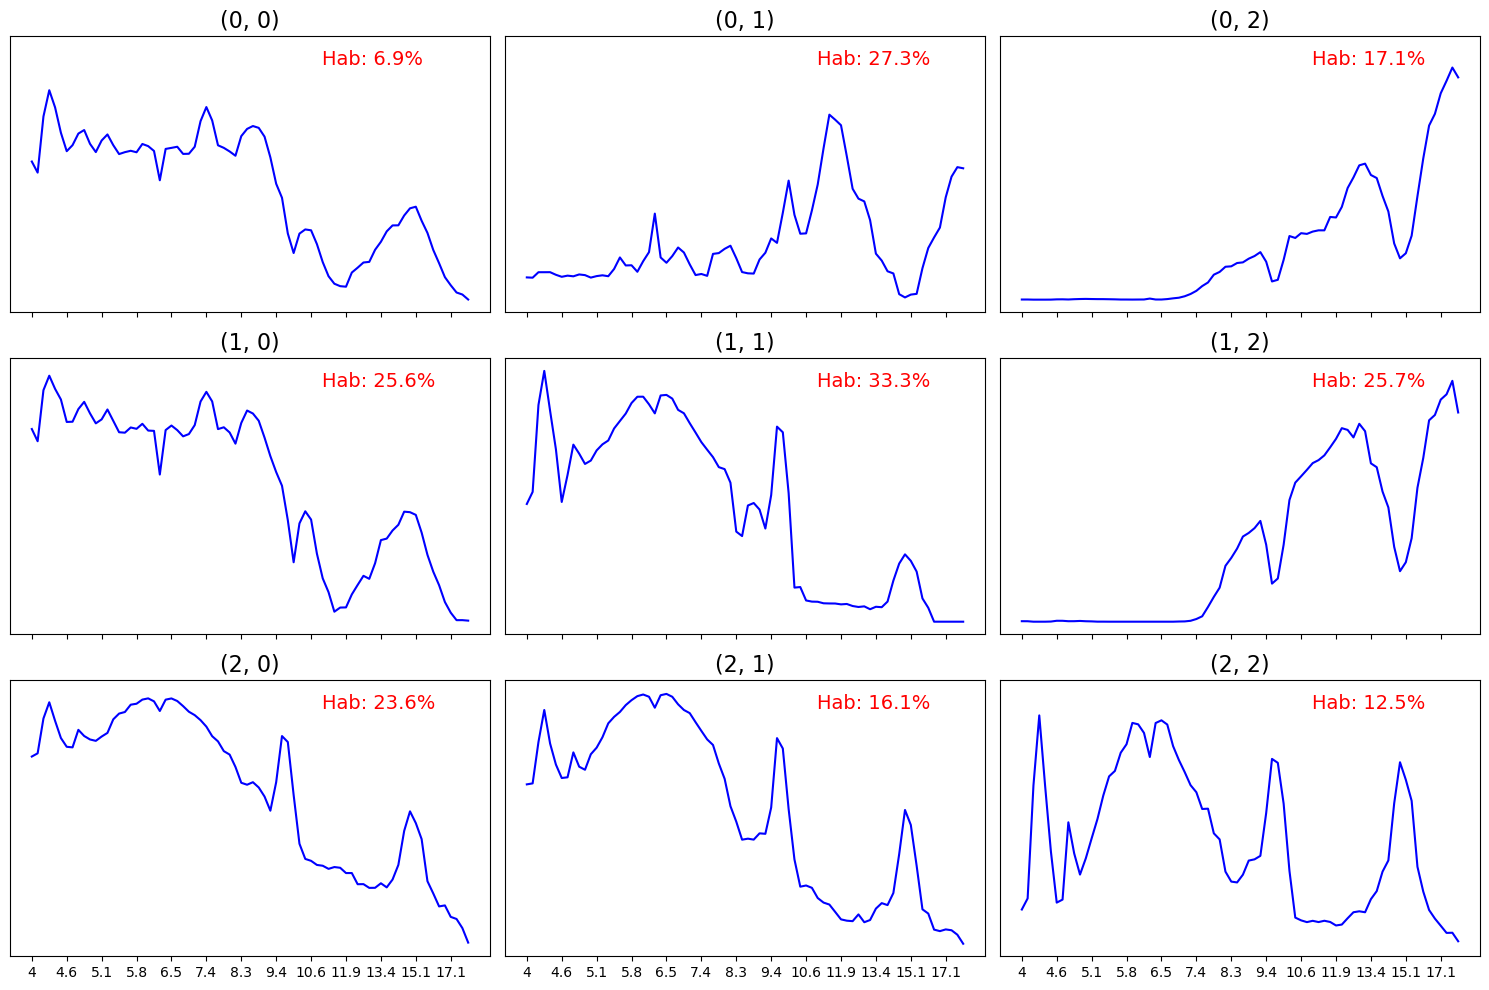

In [11]:
import matplotlib.pyplot as plt
import numpy as np

spectrum_len = all_spectra.shape[1]  # Length of the spectrum
num_x, num_y = som.x, som.y          # Size of the SOM grid
num_params = all_params.shape[1]     # Number of exoplanet parameters (6 in your case)

# Initialize arrays to store the sum of spectra and sum of parameters for each square
spectra_sum = np.zeros((num_x, num_y, spectrum_len))
spectra_square = []
params_square = []
hab_square = []
params_sum = np.zeros((num_x, num_y, num_params))
abund_sum = np.zeros((num_x, num_y, num_params-1))
hab_sum = np.zeros((num_x, num_y, 1))
counts = np.zeros((num_x, num_y))

cellx = 1
celly = 1

# Combine spectra and parameters into a single input array for SOM training
combined_input = np.hstack([all_spectra,  np.column_stack((all_params,norm_abund))])

# Loop over each data point, map it to the winning neuron, and accumulate
for i, spectrum in enumerate(all_spectra):
    # Combine spectrum and parameters into one vector
    combined_vector = np.hstack([spectrum,  np.column_stack((all_params,norm_abund))[i]])

    # Find the winning neuron (this takes both spectra and parameters into account)
    win = som.winner(combined_vector)
    # print(win)
    if win == (cellx,celly):
        spectra_square.append(np.nan_to_num(spectrum))
        hab_square.append(all_hab[i])
        params_square.append(np.column_stack((og_params,all_abund))[i])

    # Accumulate the spectra and parameters in the corresponding neuron
    spectra_sum[win] += np.nan_to_num(spectrum)  # Sum the spectra (ignoring NaNs)
    params_sum[win] += og_params[i]  # Sum the parameters
    abund_sum[win] += all_abund[i]
    hab_sum[win] += all_hab[i]
    counts[win] += 1  # Count how many data points map to each neuron

# Calculate the average spectrum and average parameters for each square
avg_spectra = np.divide(spectra_sum, counts[:, :, None], out=np.zeros_like(spectra_sum), where=counts[:, :, None] != 0)
avg_params = np.divide(params_sum, counts[:, :, None], out=np.zeros_like(params_sum), where=counts[:, :, None] != 0)
avg_abund = np.divide(abund_sum, counts[:, :, None], out=np.zeros_like(abund_sum), where=counts[:, :, None] != 0)
avg_hab = np.divide(hab_sum, counts[:, :, None], out=np.zeros_like(hab_sum), where=counts[:, :, None] != 0)

# Plot the average spectrum for each square
fig, axes = plt.subplots(num_x, num_y, figsize=(15, 10), sharex=True, sharey=True)
axes = axes.flatten()
wavelength = [4, 4.6, 5.1, 5.8, 6.5, 7.4, 8.3, 9.4, 10.6, 11.9, 13.4, 15.1, 17.1]
bins = [0, 6, 12, 18, 24, 30, 36, 42, 48, 54, 60, 66, 72]

for i in range(num_x):
    for j in range(num_y):
        ax = axes[i * num_y + j]
        ax.plot(avg_spectra[i, j], color='blue')
        ax.set_title(f'({i}, {j})', fontsize=16)
        ax.set_xticks(bins)
        ax.set_xticklabels(wavelength)  # Hide x-axis ticks
        ax.set_yticks([])  # Hide y-axis ticks
        ax.text(0.65, 0.95, f'Hab: {avg_hab[i, j, 0]*100:.1f}%', color='red', fontsize=14,
                transform=ax.transAxes, verticalalignment='top')

plt.tight_layout()
plt.show()

### Visualizing parameter distribution through SOM grid

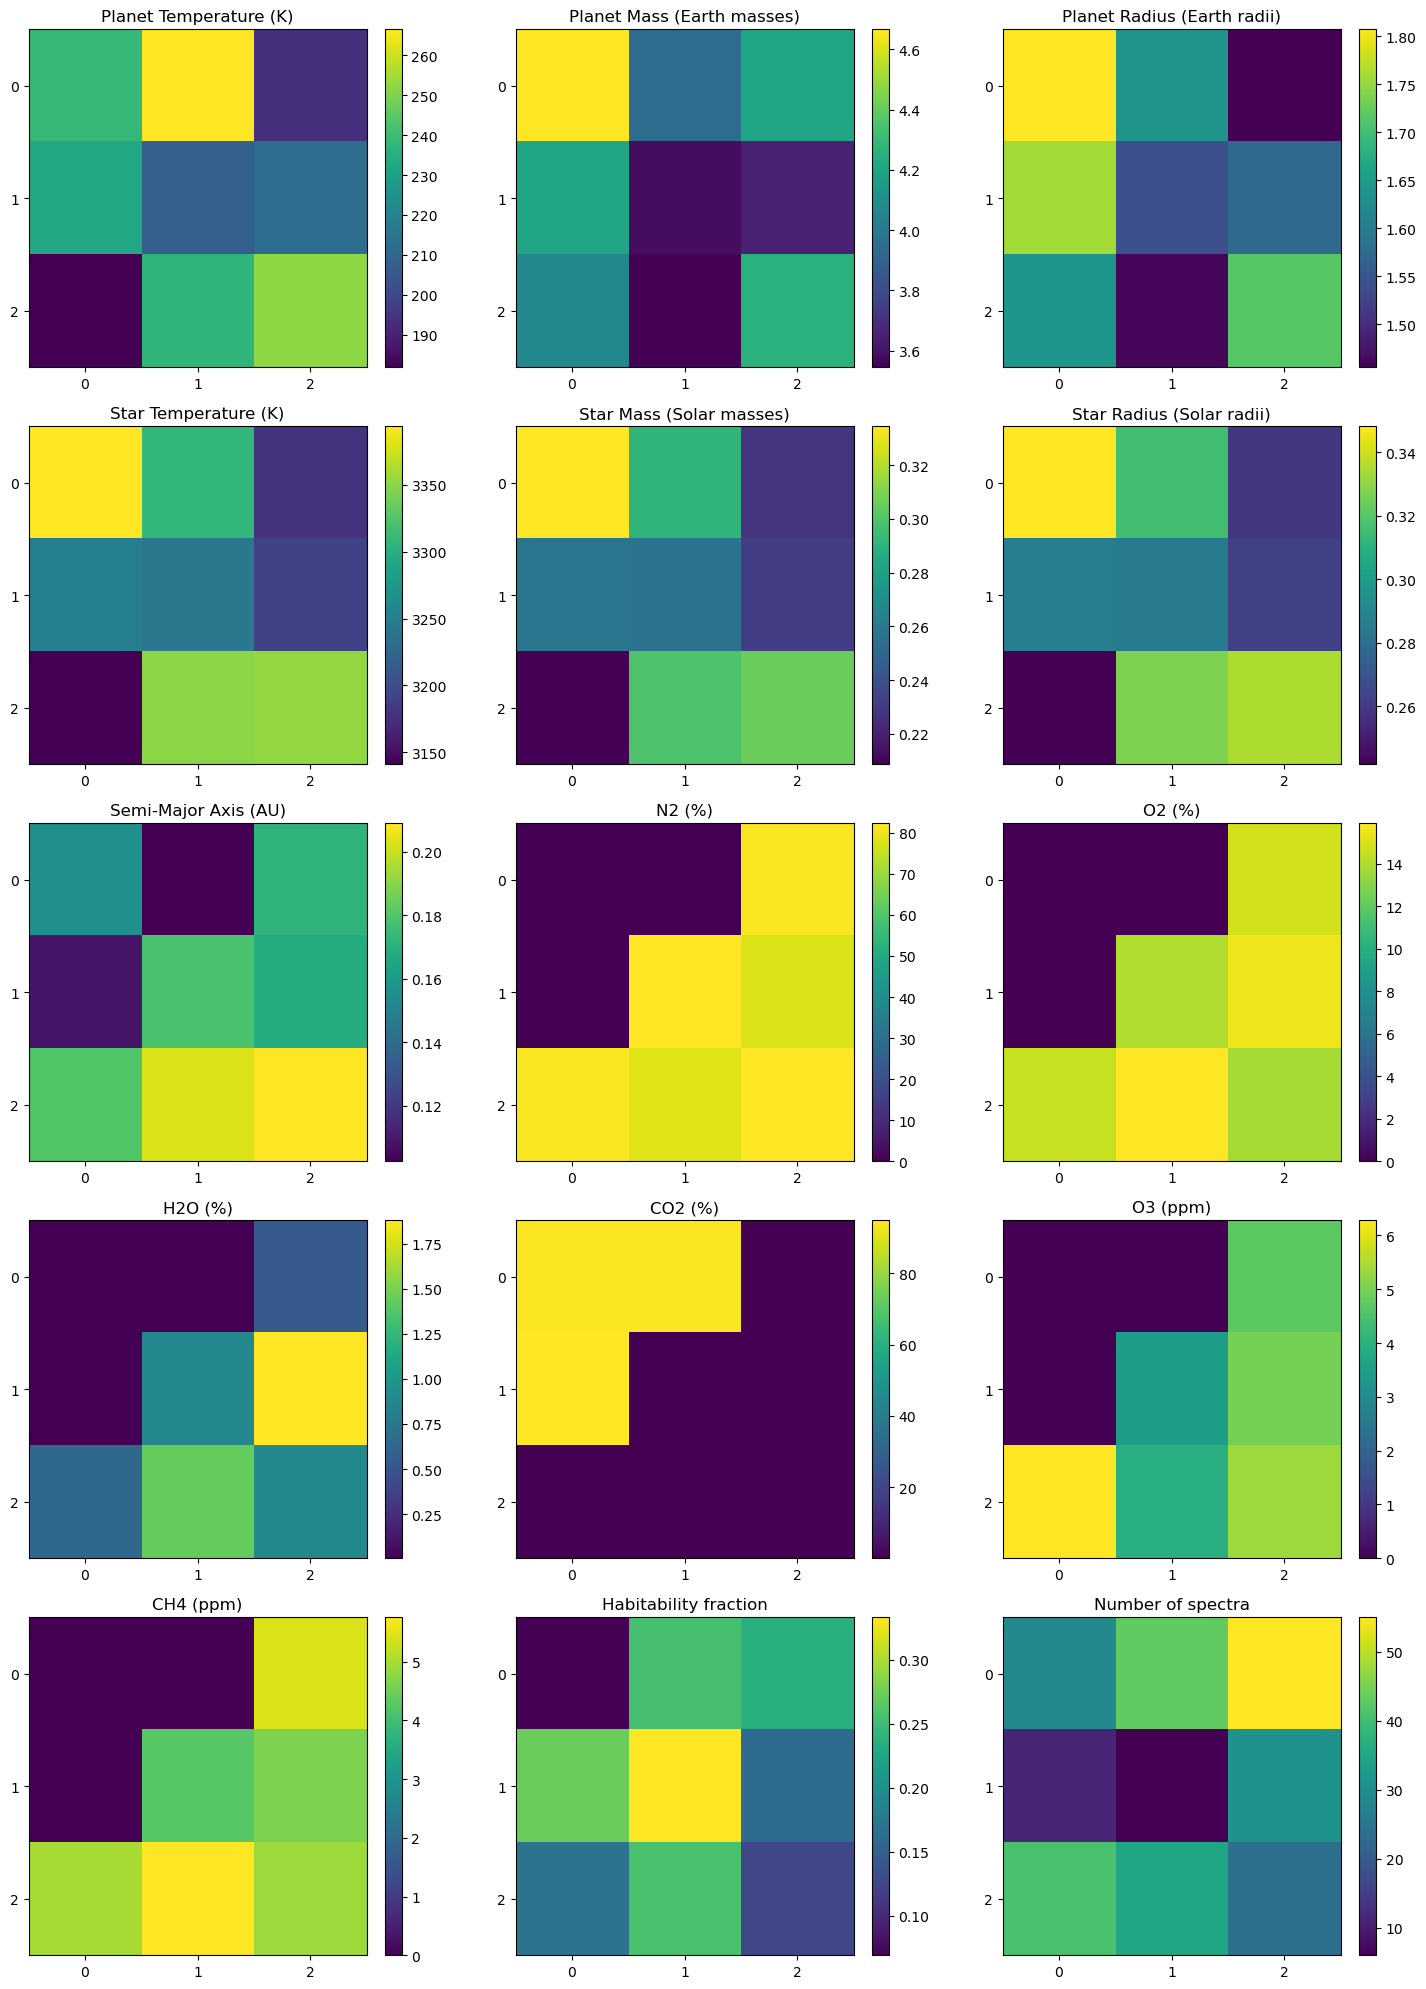

In [12]:
import matplotlib.pyplot as plt
import numpy as np

hits = np.zeros((3, 3))
for x in combined_input:
    i, j = som.winner(x)
    hits[i, j] += 1

avgall = np.concatenate((avg_params, avg_abund, avg_hab, hits.reshape(3,3,1)), axis=2)

# Define parameter names for plotting
param_names = [
    'Planet Temperature (K)',
    'Planet Mass (Earth masses)',
    'Planet Radius (Earth radii)',
    'Star Temperature (K)',
    'Star Mass (Solar masses)',
    'Star Radius (Solar radii)',
    'Semi-Major Axis (AU)',
    'N2 (%)',
    'O2 (%)',
    'H2O (%)',
    'CO2 (%)',
    'O3 (ppm)',
    'CH4 (ppm)',
    'Habitability fraction',
    'Number of spectra'
]

# Determine subplot grid layout (e.g., 2 rows x 3 columns)
n_rows, n_cols = 5, 3

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 20))

# Flatten axes array for easy indexing
axes = axes.flatten()

for p in range(len(avgall[0,0])):
    ax = axes[p]
    im = ax.imshow(avgall[:, :, p].T, cmap='viridis')
    ax.set_title(param_names[p])
    ax.set_xticks(np.arange(num_x))
    ax.set_yticks(np.arange(num_y))
    fig.colorbar(im, ax=ax, orientation='vertical', fraction=0.046, pad=0.04)

# Remove any unused subplots
for i in range(len(avgall[0,0]), n_rows * n_cols):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

### Visualization of spectra in a given SOM square

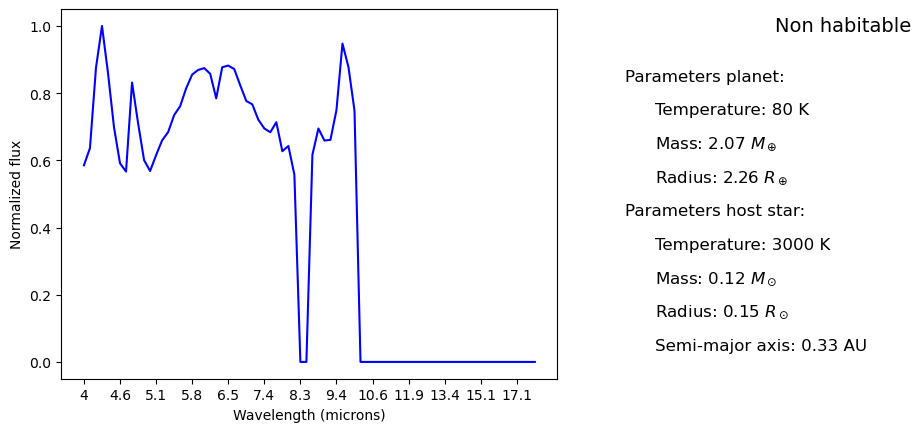

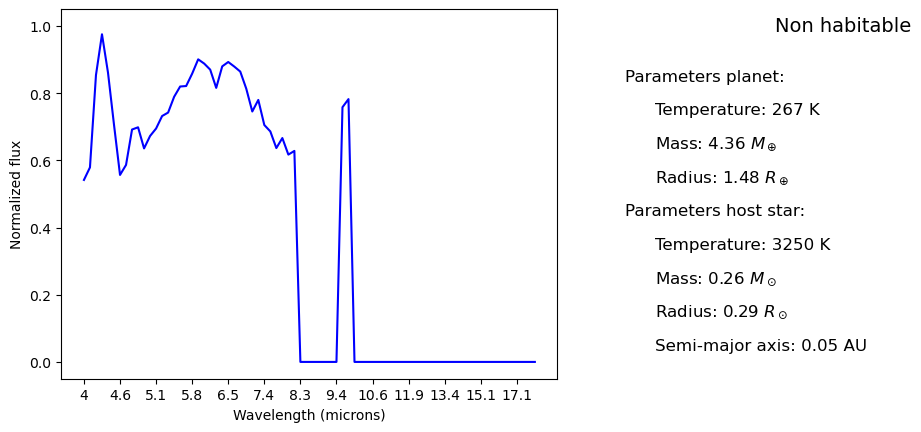

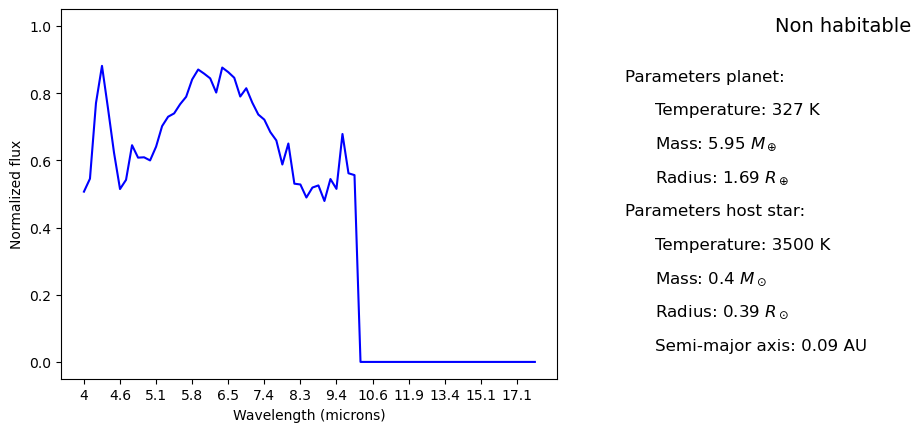

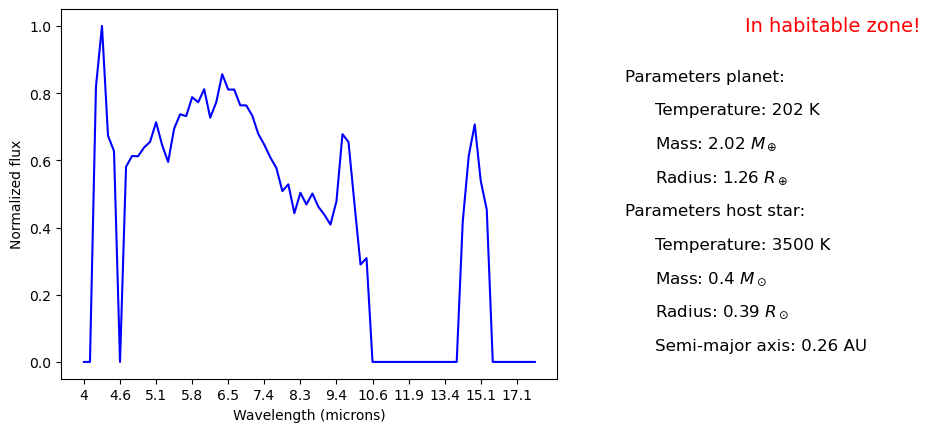

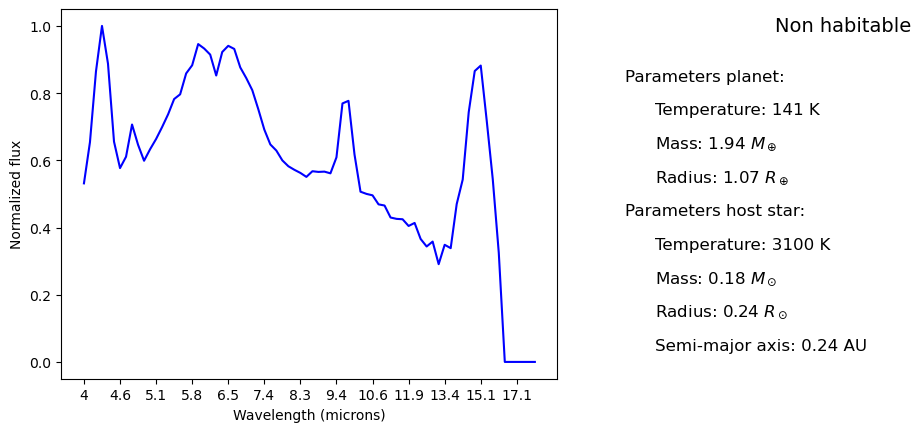

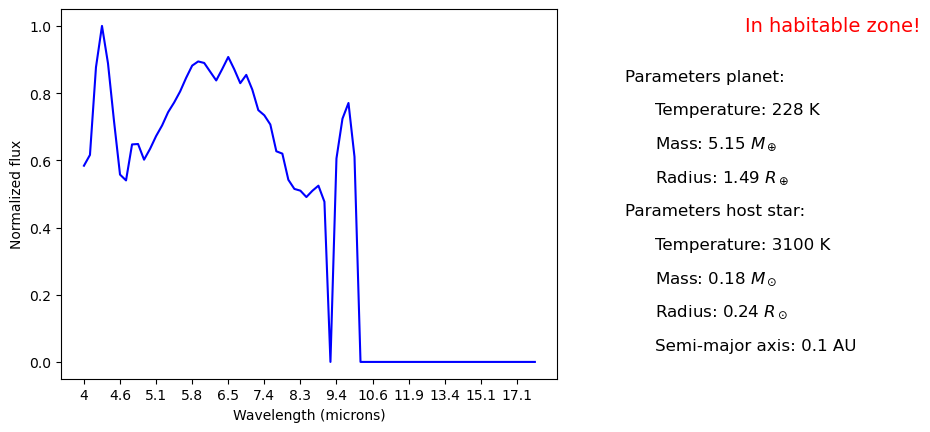

In [13]:
for i in range(len(spectra_square)):
    plt.plot(spectra_square[i],"b-")
    plt.xticks(bins,wavelength)
    plt.ylim(-0.05,1.05)
    plt.xlabel("Wavelength (microns)")
    plt.ylabel("Normalized flux")
    if hab_square[i] == 0:
        plt.text(115, 1, "Non habitable", color='black', fontsize=14, verticalalignment='center')
    else:
        plt.text(110, 1, "In habitable zone!", color='red', fontsize=14, verticalalignment='center')

    plt.text(90, 0.85, "Parameters planet:", color='black', fontsize=12, verticalalignment='center')
    plt.text(95, 0.75, "Temperature: " + str(int(params_square[i][0])) + " K", color='black', fontsize=12, verticalalignment='center')
    plt.text(95, 0.65, "Mass: " + str(round(params_square[i][1],2)) + r" $M_\oplus$", color='black', fontsize=12, verticalalignment='center')
    plt.text(95, 0.55, "Radius: " + str(round(params_square[i][2],2)) + r" $R_\oplus$", color='black', fontsize=12, verticalalignment='center')
    plt.text(90, 0.45, "Parameters host star:", color='black', fontsize=12, verticalalignment='center')
    plt.text(95, 0.35, "Temperature: " + str(int(params_square[i][3])) + " K", color='black', fontsize=12, verticalalignment='center')
    plt.text(95, 0.25, "Mass: " + str(round(params_square[i][4],2)) + r" $M_\odot$", color='black', fontsize=12, verticalalignment='center')
    plt.text(95, 0.15, "Radius: " + str(round(params_square[i][5],2)) + r" $R_\odot$", color='black', fontsize=12, verticalalignment='center')
    plt.text(95, 0.05, "Semi-major axis: " + str(round(params_square[i][6],2)) + " AU", color='black', fontsize=12, verticalalignment='center')
    # print(hab_square[i])
    plt.show()

### Studying distribution of parameters among habitable vs non-habitable exoplanets

NameError: name 'allvariables_0' is not defined

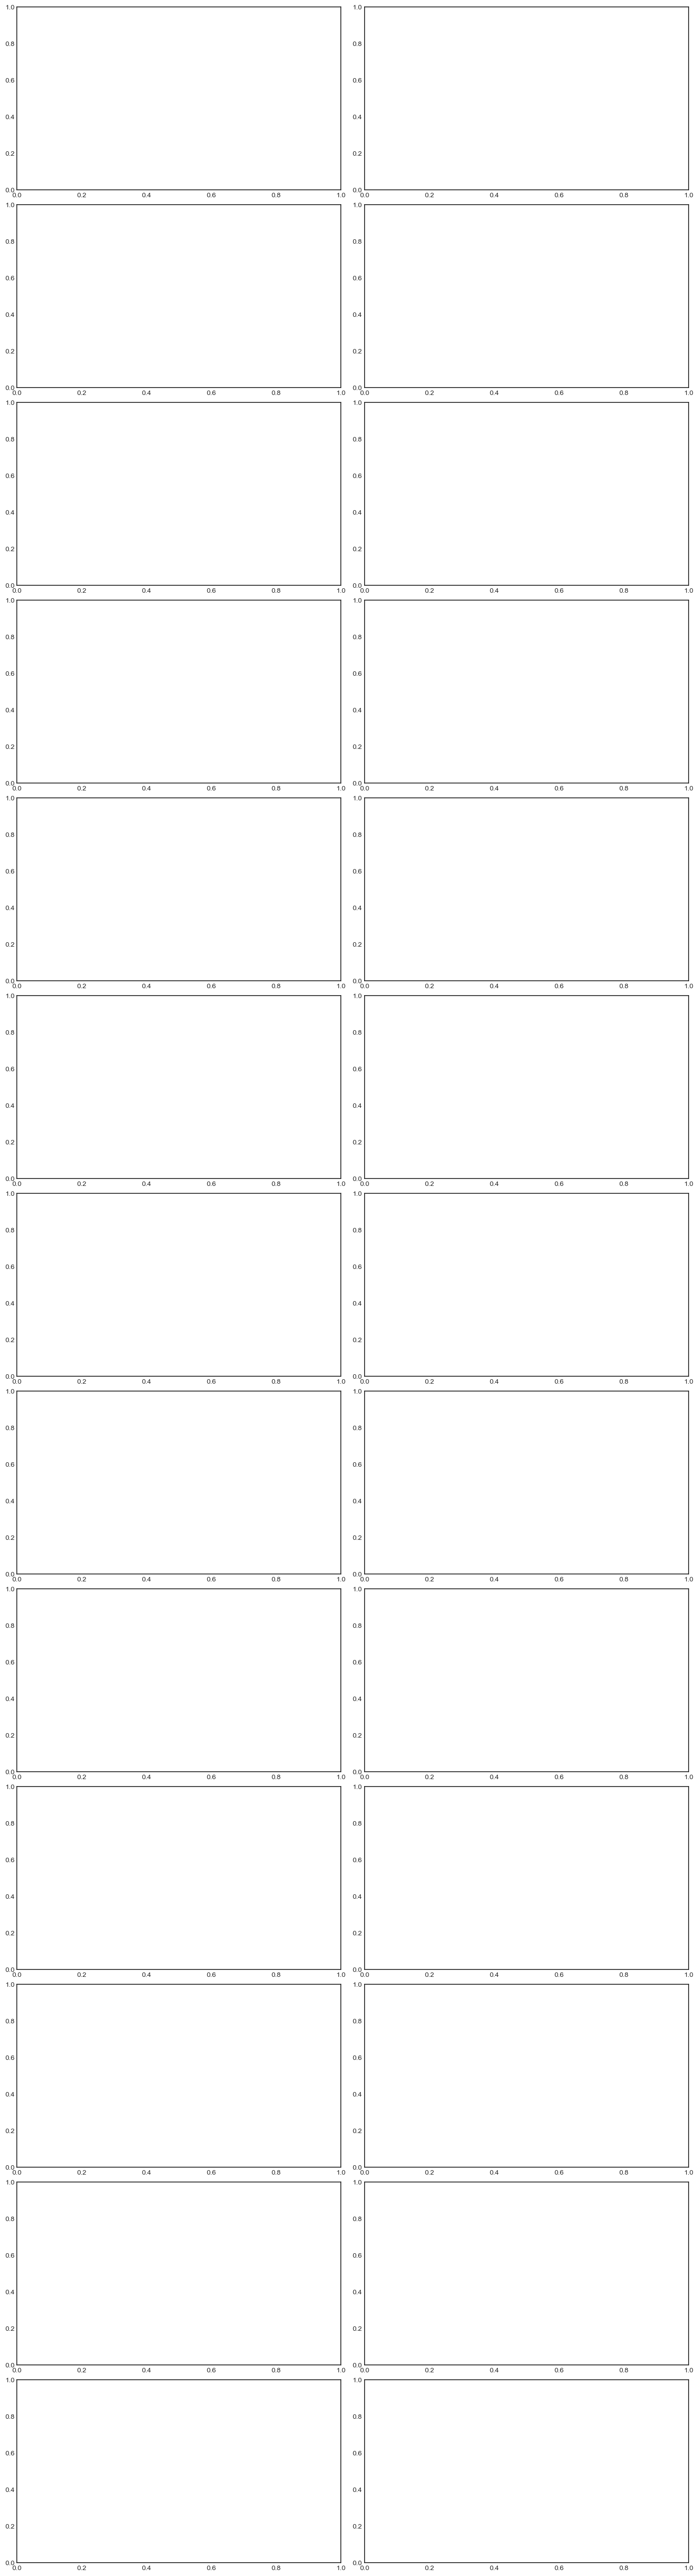

In [14]:
import numpy as np
import matplotlib.pyplot as plt

allvariables = np.hstack((og_params,all_abund))
allvariables_0, allvariables_1 = 

for i in range(len(all_hab)):
    if all_hab[i] == 0:
        

# Parameter names
param_names = [
    "Planet Temperature (K)", r"Planet Mass ($M_\oplus$)", r"Planet Radius ($R_\oplus$)",
    "Star Temperature (K)", r"Star Mass ($M_\odot$)", r"Star Radius ($R_\odot$)",
    "Semi-major Axis (AU)",
    "N2 (%)", "O2 (%)", "H2O (%)", "CO2 (%)", "O3 (ppm)", "CH4 (ppm)"
]

plt.style.use('seaborn-v0_8-white')

# Create figure and axes
fig, axes = plt.subplots(nrows=13, ncols=2, figsize=(14, 13*4), constrained_layout=True)
axes = np.array(axes).reshape(13, 2)

# Histogram settings
bin_count = 30
colors = ['#1f77b4', '#ff7f0e']  # Blue and orange

# Plot
for i, param in enumerate(param_names):
    # Left column: Non-habitable
    ax0 = axes[i, 0]
    ax0.hist(allvariables_0[:, i], bins=bin_count, color=colors[0], alpha=0.85)
    ax0.set_xlabel(param, fontsize=16)
    ax0.tick_params(axis='both', labelsize=14)

    # Get x-limits from left axis
    xlim = ax0.get_xlim()

    # Right column: Habitable
    ax1 = axes[i, 1]
    ax1.hist(allvariables_1[:, i], bins=bin_count, color=colors[1], alpha=0.85)
    ax1.set_xlim(xlim)  # Match x-axis limits
    ax1.set_xlabel(param, fontsize=16)
    ax1.tick_params(axis='both', labelsize=14)

# Column titles
axes[0, 0].set_title("Non-habitable planets", fontsize=18, weight='bold')
axes[0, 1].set_title("Habitable planets", fontsize=18, weight='bold')

# Figure title
fig.suptitle("Parameter Distributions for Exoplanet Samples", fontsize=18, weight='bold', y=1.02)

# Show the plot
plt.show()
